# TP 2: Simple neural networks

## Part 2: Implement your own Recurrent Neural Network (RNN) on a custom dataset

### 1. Load useful packages

Some of the modules will be imported only when required. But obviously, it is clearer to put these imports at the beginning of your scripts.

In [10]:
import scipy # scientific computing library
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import seaborn # advanced data plotting
from sklearn import preprocessing # basic ML models

import os
from dataclasses import dataclass
import torch

Check the version of Pytorch

In [2]:
torch.__version__

'2.6.0.dev20240917'

To execute the code on Google Collab go to tab Runtime > Change runtime type. Select GPU in Hardware accelerator

#### Set device

Check if you can use a GPU

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("CUDA is available. Using GPU.")
elif torch.backends.mps.is_available():
    device = torch.device('mps')
    print("MPS is available. Using Apple Silicon GPU.")
else:
    print("Neither CUDA nor MPS is available. Exiting.")
    exit()


MPS is available. Using Apple Silicon GPU.


In [4]:
torch.cuda.device_count()

0

Choose the device

In [5]:
device = torch.device('mps')
print(f"Using {device} device")

Using mps device


##### Manage GPU usage

From a terminal, you can launch the following command to manage GPU ressources, allocation between different users...

```bash
watch -n1 nvidia-smi
```
```-n``` means every second it is updated.

### 2. Create the dataset

You will generate a simple dataset with 1 dimension that changes over time. You'll use a `sin` function and add a bit of noise to create this dataset. The first 4000 steps will be the training dataset, and the next 2000 steps will be the validation dataset.

In [6]:
TRAIN_STEPS = 4000
VALID_STEPS = TRAIN_STEPS // 2
X = torch.sin(torch.linspace(0, 25, TRAIN_STEPS + VALID_STEPS)) + torch.randn(TRAIN_STEPS + VALID_STEPS) * 0.3


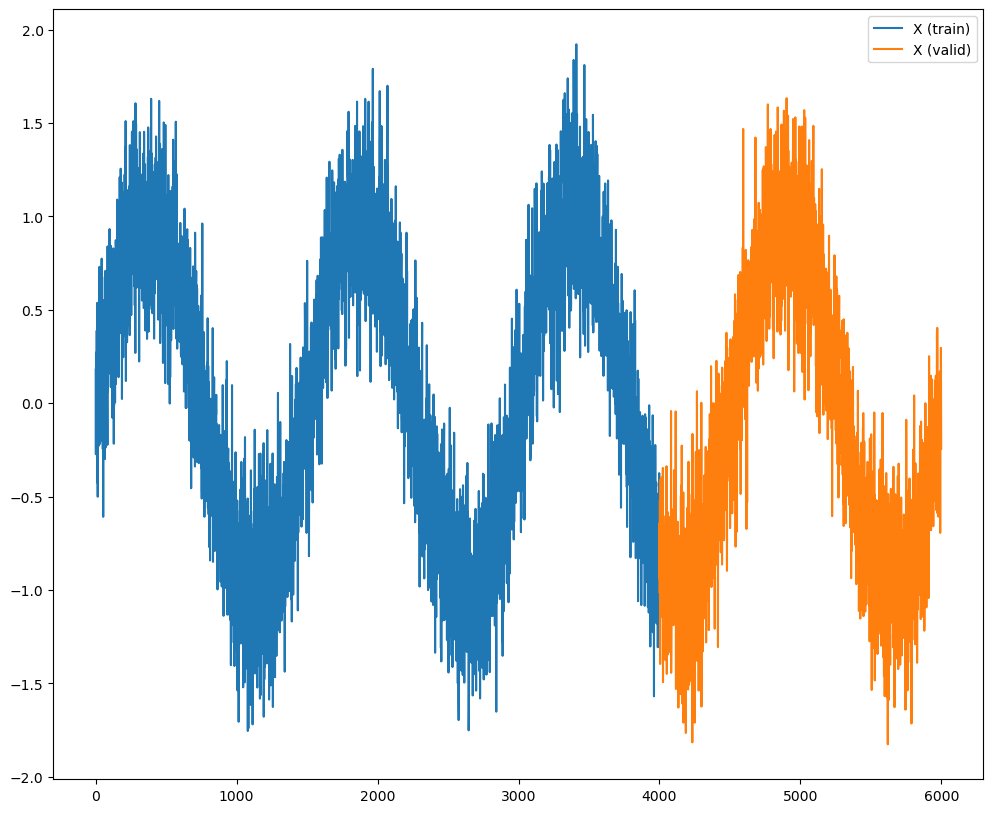

In [7]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(range(TRAIN_STEPS), X[:TRAIN_STEPS], alpha=1.0, label='X (train)')
ax.plot(range(TRAIN_STEPS, TRAIN_STEPS + VALID_STEPS), X[TRAIN_STEPS:], label='X (valid)')
ax.legend()

Split the data

In [8]:
print (X.shape)

torch.Size([6000])


Create your dataset module check `torch.utils.data.Dataset` module

Tutorial: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [14]:
from torch.utils.data import Dataset, DataLoader

@dataclass
class G:
    SERIES = X
    SPLIT_TIME = 1100
    WINDOW_SIZE = 20
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 1000

class TimeSeriesDataset(Dataset):
    def __init__(self, series, window_size=G.WINDOW_SIZE):
        self.series = series
        self.window_size = window_size

    def __len__(self):
        return len(self.series) - self.window_size

    def __getitem__(self, idx):
        return (self.series[idx:idx + self.window_size], self.series[idx + self.window_size])

# Create the dataset and DataLoader
train_dataset = TimeSeriesDataset(X[:TRAIN_STEPS])
train_loader = DataLoader(train_dataset, batch_size=G.BATCH_SIZE, shuffle=True)

# Check the size of the dataset
print("Dataset size:", len(train_dataset))

Dataset size: 3980


Convert to dataloader

### 3. Implement and train a RNN

#### Use [`nn.RNN`](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)

Initialize the model

In [23]:
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[G.WINDOW_SIZE]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

# Print the model summary
model_tune.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 20, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 20, 40)         │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 40)             │         3,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,924 (38.77 KB)

 Trainable params: 4,961 (19.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,963 (19.39 KB)

Set the loss function and the optimizer

Set the training loop and launch the training

In [25]:
# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae"])

# Train the model
history = model.fit(train_loader,epochs=100)

Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 11.3075 - mae: 11.7880
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.3779 - mae: 1.8108
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5883 - mae: 0.9649
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7927 - mae: 1.2104
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2581 - mae: 0.5808
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2808 - mae: 0.6203
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1694 - mae: 0.4720
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1897 - mae: 0.4959
Epoch 9/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2223 - mae: 0.5524
Epoch 10/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2910 - mae: 0.6216
Epoch 11/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1559 - mae: 0.4477
Epoch 12/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1306 - mae: 0.4137
Epoch 13/10

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1243 - mae: 0.3978
Epoch 72/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0690 - mae: 0.2969
Epoch 73/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0813 - mae: 0.3245
Epoch 74/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0954 - mae: 0.3505
Epoch 75/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0665 - mae: 0.2929
Epoch 76/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0680 - mae: 0.2969
Epoch 77/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0762 - mae: 0.3148
Epoch 78/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0950 - mae: 0.3396
Epoch 79/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0765 - mae: 0.3141
Epoch 80/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0686 - mae: 0.2945
Epoch 81/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0647 - mae: 0.2894
Epoch 82/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1018 - mae: 0.3646
Epoch 83/100
125/

Evaluate on the test set

ValueError: x and y can be no greater than 2D, but have shapes (4900,) and (4900, 1, 1)

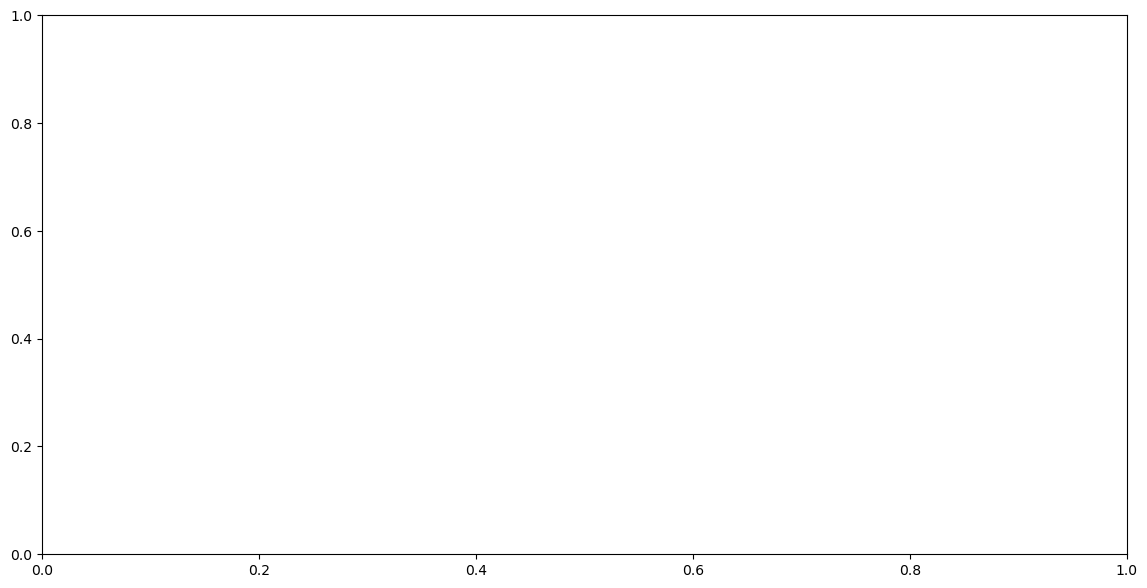

In [34]:
time_valid = range(G.SPLIT_TIME, G.SPLIT_TIME + len(results))

# Afficher les résultats
plt.figure(figsize=(14, 7))
#plt.plot(time_valid, x_valid, label='Données réelles', color='blue')
plt.plot(time_valid, results, label='Prévisions du modèle', color='orange')
plt.title('Prévisions des séries temporelles')
plt.xlabel('Temps')
plt.ylabel('Valeurs')
plt.legend()
plt.grid()
plt.show()

#### Implement your own RNN

Start by initializing a RNN cell given by $a^{<t>}=g_1(a^{<t-1>},x^{<t>})$

In [ ]:
import torch.nn as nn

class RNNCell(nn.Module):
    def __init__(self):
      # to fill

    def forward(self, x):
      # to fill

Create tha all archictecture:
1. Initialize a hidden state
2. For each time step, pass the inputs to an RNNCell, recording each output and updating the hidden state
3. Return the outputs and final hidden state


In [ ]:
class RNN(nn.Module):
    def __init__(self):
      # to fill

    def forward(self, x):
      # to fill

Initialize the model

Set the loss function and the optimizer

Set the training loop and launch the training

Evaluate on the test set